In [38]:
import pprint
from functools import partial
import baostock as bs
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from pathlib import Path
from gluonts.model.predictor import Predictor
import numpy as np


In [39]:
predictor = Predictor.deserialize(Path("./tmp/"))


In [40]:
def mygetstockdata(code):
    
   # print('login respond error_code:'+lg.error_code)
   # print('login respond  error_msg:'+lg.error_msg)
    rs = bs.query_history_k_data_plus(code,
        "date,close,volume,turn",
        start_date='2020-03-01', 
        frequency="d", adjustflag="2") #frequency="d"取日k线，adjustflag="3"默认不复权
   
    return rs.get_data()

In [41]:
import json
#liststock =['sz.300807','sz.300789','sz.300771','sz.300546','sz.300479','sz.300462','sz.300455','sz.300449','sz.300386','sz.300368']
liststock = ['sz.300462']
listdic = []
lg = bs.login()
for ite in liststock:
    dd = mygetstockdata(ite)
    dic = {"start":dd.date[0],"target":list(dd.close),"cat":int(liststock[0].split('.')[1]),"dynamic_feat":[list(dd.volume),list(dd.turn)]}
    #strjon = json.dumps(dic)
    listdic.append(dic)

bs.logout()


login success!
logout success!


In [42]:
testdata = ListDataset(
    listdic,
    freq = "1d"
)

In [43]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=testdata,  # test dataset
    predictor=predictor,  # predictor

    num_samples=100,  # number of sample paths we want for evaluation
)

In [44]:
forecasts = list(forecast_it)
tss = list(ts_it)
forecast_entry = forecasts[0]
#print(forecasts.numpy)
ts_entry = tss[0]


In [45]:
import matplotlib.pyplot as plt
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

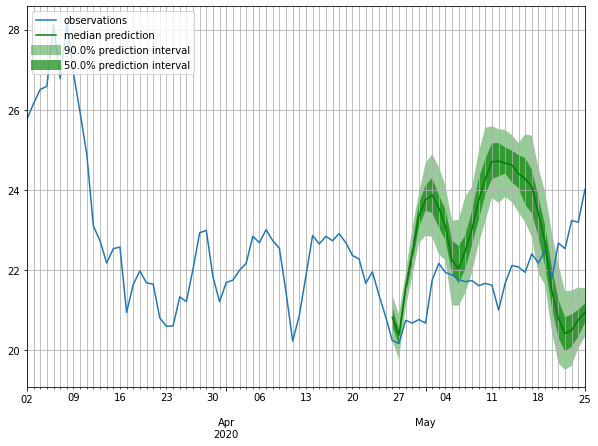

In [46]:
plot_prob_forecasts(ts_entry, forecast_entry)